In [1]:
import numpy as np
import heapq

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
torch.__version__


import matplotlib.pyplot as plt

# 使用pytorch的dataset和dataloader，并对数据进行一定的预处理

In [2]:
#读取训练集和测试机数据
transform = transforms.Compose([transforms.ToTensor() , transforms.Normalize((0.5, 0.5, 0.5) , (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# 定义函数，代码复用，每个epoch后计算训练集准确率

In [3]:
def gettrainaccuracy():
    #训练集准确率
    correct = 0.0
    total = 0
    with torch.no_grad():#不计算梯度
        for data in trainloader:
            images, labels = data#载入训练数据
            outputs = net(images)#正向传播
            _, predicted = torch.max(outputs.data, 1)#预测标签
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100.0 * correct / total
    return accuracy

def gettestaccuracy():
    #测试集准确率
    correct = 0
    total = 0
    with torch.no_grad():#不计算梯度
        for data in testloader:
            images, labels = data#载入训练数据
            outputs = net(images)#正向传播
            _, predicted = torch.max(outputs.data, 1)#预测标签
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100.0 * correct / total
    return accuracy

# 使用pytorch定义网络，2层卷积层、2层池化层、3层全连接层，最终未连接softmax(因为pytorch的交叉熵损失函数内部包含有softmax)，训练时使用单张图像

In [4]:
epochnum = 100

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #定义两个卷积层、两个池化层、三个全连接层
        #CIFAR-10数据集图像大小为(32,32,3)
        self.conv1 = nn.Conv2d(3, 6, 5)
        #conv1输入3个通道(RGB)，有6个卷积核，卷积核大小为5*5
        #输出6个通道(每个卷积核一个)，28*28的数据。计算公式：(img_size - kernel_size + 2 * padding)/stride + 1。结果为(32-5)/1 + 1= 28 
        #输出(6,28,28)
        self.pool = nn.MaxPool2d(2, 2)#2*2最大池化
        #第一次池化，输出(6,14,14)。28 / 2 = 14
        #第二次池化，输出(16,5,5)。10 / 2 = 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        #conv1输入6个通道，有16个卷积核，卷积核大小为5*5
        #输出16个通道(每个卷积核一个)，10*10的数据。计算过程为(14-5)/1 + 1= 10
        #输出(16,10,10)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #全连接层，输入(16,5,5)的数据，输出120个节点
        self.fc2 = nn.Linear(120, 84) #全连接层，120个连接84个
        self.fc3 = nn.Linear(84, 10) #全连接层，84个连接10个
        #

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #第一次卷积、relu激活、池化。输出(6,14,14)的数据
        x = self.pool(F.relu(self.conv2(x))) #第二次卷积、relu激活、池化。输出(16,5,5)的数据
        x = x.view(-1, x.size()[1:].numel()) #将数据展开成一维
        x = F.relu(self.fc1(x)) #第一层全连接、relu激活
        x = F.relu(self.fc2(x)) #第二层全连接、relu激活
        x = self.fc3(x) #第三层全连接，得到评分
        return x

In [6]:
#训练
torch.manual_seed(410)      
np.random.seed(410)

net = Net() #实例化网络
criterion = nn.CrossEntropyLoss() #交叉熵损失
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #构造优化器
correct = 0
total = 0

trainaccuracy0 = np.zeros(epochnum)
testaccuracy0 = np.zeros(epochnum)
for epoch in range(epochnum):  # 多批次循环
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data
        # 梯度置0
        optimizer.zero_grad()
        
        outputs = net(inputs)#正向传播
        loss = criterion(outputs, labels)#计算损失
        loss.backward()#反向传播
        optimizer.step()#更新网络参数
        
        _, predicted = torch.max(outputs.data, 1)#预测标签
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # 打印损失信息
        running_loss += loss.item()
        if i % 500 == 499:    # 每2000批次打印一次
            #print('[%d, %5d] loss: %.3f accuracy: %f %%' % (epoch + 1, (i + 1) * 4, running_loss / total , 100 * correct / total))
            running_loss = 0.0
            correct = 0
            total = 0
    trainaccuracy0[epoch] = gettrainaccuracy()
    testaccuracy0[epoch] = gettestaccuracy()
    print('Finished epoch ',epoch + 1)
print('Finished Training')

Finished epoch  1
Finished epoch  2
Finished epoch  3
Finished epoch  4
Finished epoch  5
Finished epoch  6
Finished epoch  7
Finished epoch  8
Finished epoch  9
Finished epoch  10
Finished epoch  11
Finished epoch  12
Finished epoch  13
Finished epoch  14
Finished epoch  15
Finished epoch  16
Finished epoch  17
Finished epoch  18
Finished epoch  19
Finished epoch  20
Finished epoch  21
Finished epoch  22
Finished epoch  23
Finished epoch  24
Finished epoch  25
Finished epoch  26
Finished epoch  27
Finished epoch  28
Finished epoch  29
Finished epoch  30
Finished epoch  31
Finished epoch  32
Finished epoch  33
Finished epoch  34
Finished epoch  35
Finished epoch  36
Finished epoch  37
Finished epoch  38
Finished epoch  39
Finished epoch  40
Finished epoch  41
Finished epoch  42
Finished epoch  43
Finished epoch  44
Finished epoch  45
Finished epoch  46
Finished epoch  47
Finished epoch  48
Finished epoch  49
Finished epoch  50
Finished epoch  51
Finished epoch  52
Finished epoch  53
Fi

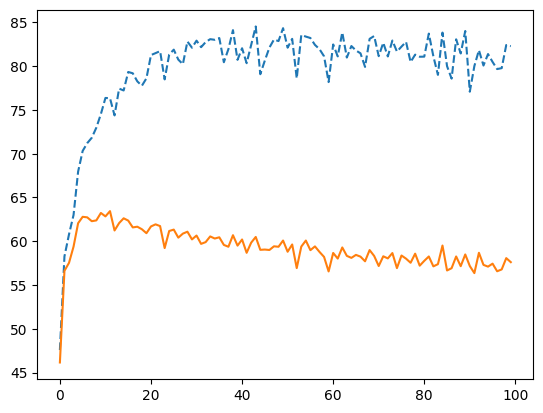

In [7]:
plt.plot(range(epochnum),trainaccuracy0,linestyle='--')
plt.plot(range(epochnum),testaccuracy0,linestyle='-')

# 增加dropout层

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #定义两个卷积层、两个池化层、三个全连接层
        #CIFAR-10数据集图像大小为(32,32,3)
        self.conv1 = nn.Conv2d(3, 6, 5)
        #conv1输入3个通道(RGB)，有6个卷积核，卷积核大小为5*5
        #输出6个通道(每个卷积核一个)，28*28的数据。计算公式：(img_size - kernel_size + 2 * padding)/stride + 1。结果为(32-5)/1 + 1= 28 
        #输出(6,28,28)
        self.pool = nn.MaxPool2d(2, 2)#2*2最大池化
        #第一次池化，输出(6,14,14)。28 / 2 = 14
        #第二次池化，输出(16,5,5)。10 / 2 = 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        #conv1输入6个通道，有16个卷积核，卷积核大小为5*5
        #输出16个通道(每个卷积核一个)，10*10的数据。计算过程为(14-5)/1 + 1= 10
        #输出(16,10,10)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #全连接层，输入(16,5,5)的数据，输出120个节点
        self.fc2 = nn.Linear(120, 84) #全连接层，120个连接84个
        self.fc3 = nn.Linear(84, 10) #全连接层，84个连接10个
        
        self.dropout = nn.Dropout(p = 0.3) #神经元有0.3的概率不被激活
        #

    def forward(self, x):
        x = self.pool(F.relu(self.dropout(self.conv1(x)))) #第一次卷积、relu激活、池化。输出(6,14,14)的数据
        x = self.pool(F.relu(self.dropout(self.conv2(x)))) #第二次卷积、relu激活、池化。输出(16,5,5)的数据
        x = x.view(-1, x.size()[1:].numel()) #将数据展开成一维
        x = F.relu(self.dropout(self.fc1(x))) #第一层全连接、relu激活
        x = F.relu(self.dropout(self.fc2(x))) #第二层全连接、relu激活
        x = self.fc3(x) #第三层全连接，得到评分
        return x

In [9]:
#训练
torch.manual_seed(410)      
np.random.seed(410)

net = Net() #实例化网络
criterion = nn.CrossEntropyLoss() #交叉熵损失
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #构造优化器
correct = 0
total = 0

trainaccuracy1 = np.zeros(epochnum)
testaccuracy1 = np.zeros(epochnum)
for epoch in range(epochnum):  # 多批次循环
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data
        # 梯度置0
        optimizer.zero_grad()
        
        outputs = net(inputs)#正向传播
        loss = criterion(outputs, labels)#计算损失
        loss.backward()#反向传播
        optimizer.step()#更新网络参数
        
        _, predicted = torch.max(outputs.data, 1)#预测标签
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # 打印损失信息
        running_loss += loss.item()
        if i % 500 == 499:    # 每2000批次打印一次
            #print('[%d, %5d] loss: %.3f accuracy: %f %%' % (epoch + 1, (i + 1) * 4, running_loss / total , 100 * correct / total))
            running_loss = 0.0
            correct = 0
            total = 0
    trainaccuracy1[epoch] = gettrainaccuracy()
    testaccuracy1[epoch] = gettestaccuracy()
    print('Finished epoch ',epoch + 1)
print('Finished Training')

Finished epoch  1
Finished epoch  2
Finished epoch  3
Finished epoch  4
Finished epoch  5
Finished epoch  6
Finished epoch  7
Finished epoch  8
Finished epoch  9
Finished epoch  10
Finished epoch  11
Finished epoch  12
Finished epoch  13
Finished epoch  14
Finished epoch  15
Finished epoch  16
Finished epoch  17
Finished epoch  18
Finished epoch  19
Finished epoch  20
Finished epoch  21
Finished epoch  22
Finished epoch  23
Finished epoch  24
Finished epoch  25
Finished epoch  26
Finished epoch  27
Finished epoch  28
Finished epoch  29
Finished epoch  30
Finished epoch  31
Finished epoch  32
Finished epoch  33
Finished epoch  34
Finished epoch  35
Finished epoch  36
Finished epoch  37
Finished epoch  38
Finished epoch  39
Finished epoch  40
Finished epoch  41
Finished epoch  42
Finished epoch  43
Finished epoch  44
Finished epoch  45
Finished epoch  46
Finished epoch  47
Finished epoch  48
Finished epoch  49
Finished epoch  50
Finished epoch  51
Finished epoch  52
Finished epoch  53
Fi

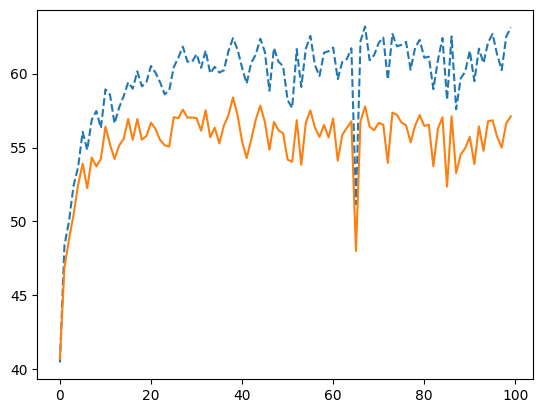

In [10]:
plt.plot(range(epochnum),trainaccuracy1,linestyle='--')
plt.plot(range(epochnum),testaccuracy1,linestyle='-')

# 增加BN层

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #定义两个卷积层、两个池化层、三个全连接层
        #CIFAR-10数据集图像大小为(32,32,3)
        self.conv1 = nn.Conv2d(3, 6, 5)
        #conv1输入3个通道(RGB)，有6个卷积核，卷积核大小为5*5
        #输出6个通道(每个卷积核一个)，28*28的数据。计算公式：(img_size - kernel_size + 2 * padding)/stride + 1。结果为(32-5)/1 + 1= 28 
        #输出(6,28,28)
        self.bn1 = nn.BatchNorm2d(6) #第一层卷积出来有6个特征
        self.pool = nn.MaxPool2d(2, 2)#2*2最大池化
        #第一次池化，输出(6,14,14)。28 / 2 = 14
        #第二次池化，输出(16,5,5)。10 / 2 = 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        #conv1输入6个通道，有16个卷积核，卷积核大小为5*5
        #输出16个通道(每个卷积核一个)，10*10的数据。计算过程为(14-5)/1 + 1= 10
        #输出(16,10,10)
        self.bn2 = nn.BatchNorm2d(16) #第二层卷积出来有16个特征
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #全连接层，输入(16,5,5)的数据，输出120个节点
        self.fc2 = nn.Linear(120, 84) #全连接层，120个连接84个
        self.fc3 = nn.Linear(84, 10) #全连接层，84个连接10个
        
        self.dropout = nn.Dropout(p = 0.3) #神经元有0.3的概率不被激活
        #

    def forward(self, x):
        x = self.conv1(x) #第一次卷积、
        x = self.bn1(x) #BN层
        x = F.relu(x) #relu激活
        x = self.pool(x) #池化。输出(6,14,14)的数据
        
        x = self.conv2(x) #第二次卷积
        x = self.bn2(x) #BN层
        x = F.relu(x) #relu激活
        x = self.pool(x) #池化。输出(16,5,5)的数据
        
        x = x.view(-1, x.size()[1:].numel()) #将数据展开成一维
        x = self.fc1(x)#第一层全连接
        x = F.relu(x) #relu激活
        x = self.fc2(x) #第二层全连接
        x = F.relu(x) #relu激活
        x = self.fc3(x) #第三层全连接，得到评分
        return x

In [12]:
#训练
torch.manual_seed(410)      
np.random.seed(410)

net = Net() #实例化网络
criterion = nn.CrossEntropyLoss() #交叉熵损失
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #构造优化器
correct = 0
total = 0

trainaccuracy2 = np.zeros(epochnum)
testaccuracy2 = np.zeros(epochnum)
for epoch in range(epochnum):  # 多批次循环
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data
        # 梯度置0
        optimizer.zero_grad()
        
        outputs = net(inputs)#正向传播
        loss = criterion(outputs, labels)#计算损失
        loss.backward()#反向传播
        optimizer.step()#更新网络参数
        
        _, predicted = torch.max(outputs.data, 1)#预测标签
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # 打印损失信息
        running_loss += loss.item()
        if i % 500 == 499:    # 每2000批次打印一次
            #print('[%d, %5d] loss: %.3f accuracy: %f %%' % (epoch + 1, (i + 1) * 4, running_loss / total , 100 * correct / total))
            running_loss = 0.0
            correct = 0
            total = 0
    trainaccuracy2[epoch] = gettrainaccuracy()
    testaccuracy2[epoch] = gettestaccuracy()
    print('Finished epoch ',epoch + 1)
print('Finished Training')

Finished epoch  1
Finished epoch  2
Finished epoch  3
Finished epoch  4
Finished epoch  5
Finished epoch  6
Finished epoch  7
Finished epoch  8
Finished epoch  9
Finished epoch  10
Finished epoch  11
Finished epoch  12
Finished epoch  13
Finished epoch  14
Finished epoch  15
Finished epoch  16
Finished epoch  17
Finished epoch  18
Finished epoch  19
Finished epoch  20
Finished epoch  21
Finished epoch  22
Finished epoch  23
Finished epoch  24
Finished epoch  25
Finished epoch  26
Finished epoch  27
Finished epoch  28
Finished epoch  29
Finished epoch  30
Finished epoch  31
Finished epoch  32
Finished epoch  33
Finished epoch  34
Finished epoch  35
Finished epoch  36
Finished epoch  37
Finished epoch  38
Finished epoch  39
Finished epoch  40
Finished epoch  41
Finished epoch  42
Finished epoch  43
Finished epoch  44
Finished epoch  45
Finished epoch  46
Finished epoch  47
Finished epoch  48
Finished epoch  49
Finished epoch  50
Finished epoch  51
Finished epoch  52
Finished epoch  53
Fi

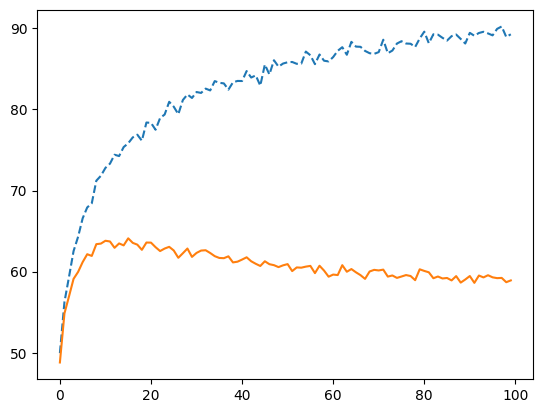

In [13]:
plt.plot(range(epochnum),trainaccuracy2,linestyle='--')
plt.plot(range(epochnum),testaccuracy2,linestyle='-')

# 增加LN层

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #定义两个卷积层、两个池化层、三个全连接层
        #CIFAR-10数据集图像大小为(32,32,3)
        self.conv1 = nn.Conv2d(3, 6, 5)
        #conv1输入3个通道(RGB)，有6个卷积核，卷积核大小为5*5
        #输出6个通道(每个卷积核一个)，28*28的数据。计算公式：(img_size - kernel_size + 2 * padding)/stride + 1。结果为(32-5)/1 + 1= 28 
        #输出(6,28,28)
        self.ln1 = nn.LayerNorm([6,28,28]) #第一层卷积出来维度为(6,28,28)
        self.pool = nn.MaxPool2d(2, 2)#2*2最大池化
        #第一次池化，输出(6,14,14)。28 / 2 = 14
        #第二次池化，输出(16,5,5)。10 / 2 = 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        #conv1输入6个通道，有16个卷积核，卷积核大小为5*5
        #输出16个通道(每个卷积核一个)，10*10的数据。计算过程为(14-5)/1 + 1= 10
        #输出(16,10,10)
        self.ln2 =nn.LayerNorm([16,10,10]) #第二层卷积出来有16个特征
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #全连接层，输入(16,5,5)的数据，输出120个节点
        self.fc2 = nn.Linear(120, 84) #全连接层，120个连接84个
        self.fc3 = nn.Linear(84, 10) #全连接层，84个连接10个
        
        self.dropout = nn.Dropout(p = 0.3) #神经元有0.3的概率不被激活
        #

    def forward(self, x):
        x = self.conv1(x) #第一次卷积、
        x = self.ln1(x) #LN层
        x = F.relu(x) #relu激活
        x = self.pool(x) #池化。输出(6,14,14)的数据
        
        x = self.conv2(x) #第二次卷积
        x = self.ln2(x) #LN层
        x = F.relu(x) #relu激活
        x = self.pool(x) #池化。输出(16,5,5)的数据
        
        x = x.view(-1, x.size()[1:].numel()) #将数据展开成一维
        x = self.fc1(x)#第一层全连接
        x = F.relu(x) #relu激活
        x = self.fc2(x) #第二层全连接
        x = F.relu(x) #relu激活
        x = self.fc3(x) #第三层全连接，得到评分
        return x

In [15]:
#训练
torch.manual_seed(410)      
np.random.seed(410)

net = Net() #实例化网络
criterion = nn.CrossEntropyLoss() #交叉熵损失
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #构造优化器
correct = 0
total = 0

trainaccuracy3 = np.zeros(epochnum)
testaccuracy3 = np.zeros(epochnum)
for epoch in range(epochnum):  # 多批次循环
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data
        # 梯度置0
        optimizer.zero_grad()
        
        outputs = net(inputs)#正向传播
        loss = criterion(outputs, labels)#计算损失
        loss.backward()#反向传播
        optimizer.step()#更新网络参数
        
        _, predicted = torch.max(outputs.data, 1)#预测标签
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # 打印损失信息
        running_loss += loss.item()
        if i % 500 == 499:    # 每2000批次打印一次
            #print('[%d, %5d] loss: %.3f accuracy: %f %%' % (epoch + 1, (i + 1) * 4, running_loss / total , 100 * correct / total))
            running_loss = 0.0
            correct = 0
            total = 0
    trainaccuracy3[epoch] = gettrainaccuracy()
    testaccuracy3[epoch] = gettestaccuracy()
    print('Finished epoch ',epoch + 1)
print('Finished Training')

Finished epoch  1
Finished epoch  2
Finished epoch  3
Finished epoch  4
Finished epoch  5
Finished epoch  6
Finished epoch  7
Finished epoch  8
Finished epoch  9
Finished epoch  10
Finished epoch  11
Finished epoch  12
Finished epoch  13
Finished epoch  14
Finished epoch  15
Finished epoch  16
Finished epoch  17
Finished epoch  18
Finished epoch  19
Finished epoch  20
Finished epoch  21
Finished epoch  22
Finished epoch  23
Finished epoch  24
Finished epoch  25
Finished epoch  26
Finished epoch  27
Finished epoch  28
Finished epoch  29
Finished epoch  30
Finished epoch  31
Finished epoch  32
Finished epoch  33
Finished epoch  34
Finished epoch  35
Finished epoch  36
Finished epoch  37
Finished epoch  38
Finished epoch  39
Finished epoch  40
Finished epoch  41
Finished epoch  42
Finished epoch  43
Finished epoch  44
Finished epoch  45
Finished epoch  46
Finished epoch  47
Finished epoch  48
Finished epoch  49
Finished epoch  50
Finished epoch  51
Finished epoch  52
Finished epoch  53
Fi

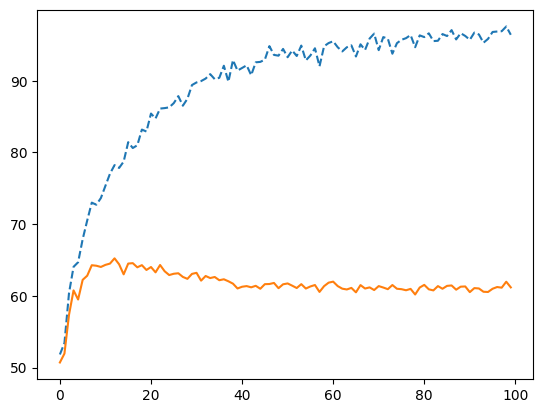

In [16]:
plt.plot(range(epochnum),trainaccuracy3,linestyle='--')
plt.plot(range(epochnum),testaccuracy3,linestyle='-')

# 所有对比

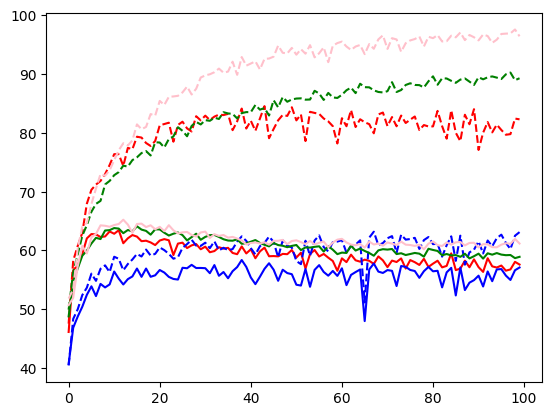

In [17]:
plt.plot(range(epochnum),trainaccuracy0,color='red',linestyle='--',label = 'none')
plt.plot(range(epochnum),testaccuracy0,color='red',linestyle='-',label = 'none')

plt.plot(range(epochnum),trainaccuracy1,color='blue',linestyle='--',label = 'dropout')
plt.plot(range(epochnum),testaccuracy1,color='blue',linestyle='-',label = 'dropout')

plt.plot(range(epochnum),trainaccuracy2,color='green',linestyle='--',label = 'BN')
plt.plot(range(epochnum),testaccuracy2,color='green',linestyle='-',label = 'BN')

plt.plot(range(epochnum),trainaccuracy3,color='pink',linestyle='--',label = 'LN')
plt.plot(range(epochnum),testaccuracy3,color='pink',linestyle='-',label = 'LN')